In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from datetime import datetime
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
seed=42
# utils.seed_everything(seed=seed)

# if utils.is_interactive():
#     %load_ext autoreload
#     %autoreload 2

# from models import Clipper
# clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=True, device=device)
imsize = 512

/root/miniconda3/envs/EEG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


In [2]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/root/autodl-tmp/EEG/EEG_Image_decode/Generation/Generation/generated_imgs/sub-08'
target_dir = '/root/autodl-tmp/EEG/EEG_Image_decode/Generation/Generation/generated_imgs_tensor'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Initialize a list to hold all the image tensors
tensor_list = []

# Iterate over the folders in the source directory
for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Iterate over the images in the folder
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            
            # Load the image
            with Image.open(image_path) as img:
                # Convert the image to a PyTorch tensor and add a batch dimension
                tensor = torch.tensor(np.array(img)).unsqueeze(0)
                tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "all_images_sub08.pt")
torch.save(all_tensors, combined_tensor_path)

In [16]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/root/autodl-tmp/EEG/EEG_Image_decode/datasets/THINGS/images_set/test_images'
target_dir = '/root/autodl-tmp/EEG/EEG_Image_decode/datasets/THINGS/images_set/test_images_tensor'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Initialize a list to hold all the image tensors
tensor_list = []

# Iterate over the folders in the source directory
for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Iterate over the images in the folder
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            
            # Load the image
            with Image.open(image_path) as img:
                # Convert the image to a PyTorch tensor and add a batch dimension
                tensor = torch.tensor(np.array(img)).unsqueeze(0)
                tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "all_images.pt")
torch.save(all_tensors, combined_tensor_path)

In [2]:
recon_path = '/root/autodl-tmp/EEG/EEG_Image_decode/Generation/Generation/generated_imgs_tensor/all_images.pt'
all_images_path = '/root/autodl-tmp/EEG/EEG_Image_decode/datasets/THINGS/images_set/test_images_tensor/all_images.pt'
all_brain_recons = torch.load(f'{recon_path}')
all_images = torch.load(f'{all_images_path}')

print(all_images.shape)
print(all_brain_recons.shape)

# all_images = all_images[:3].to(device)
# all_brain_recons = all_brain_recons[:30].to(device).to(all_images.dtype).clamp(0,1)

# print(all_images.shape)
# print(all_brain_recons.shape)

torch.Size([200, 500, 500, 3])
torch.Size([2000, 512, 512, 3])


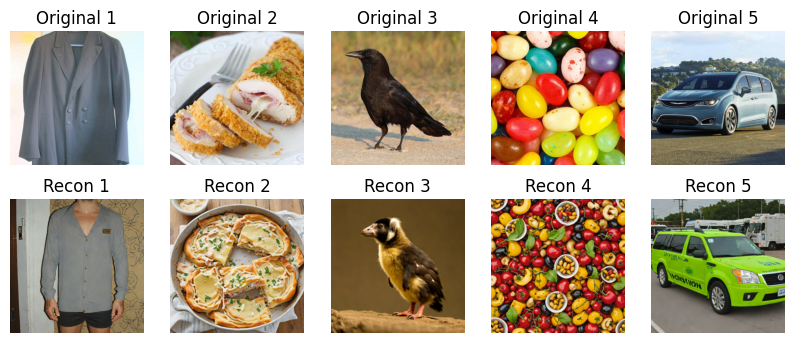

In [26]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Paths to the original and generated images
source_dir_original = '/root/autodl-tmp/EEG/EEG_Image_decode/datasets/THINGS/images_set/test_images'
source_dir_generated = '/root/autodl-tmp/EEG/EEG_Image_decode/Generation/Generation/generated_imgs/sub-08'

# Define a function to load and resize images to 512x512
def load_and_resize_image(image_path, size=(512, 512)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img_tensor = transforms.ToTensor()(img)
    return img_tensor

# Get the categories and limit to the first 10
# categories = os.listdir(source_dir_original)[111:121]
# selected_indices = [1, 3, 6, 10, 11, 44, 50, 57, 100, 114]
selected_indices = [44, 50, 57, 100, 114]
categories = [os.listdir(source_dir_original)[i] for i in selected_indices]

# Prepare to save the comparisons in a figure with 2 rows (originals and first generated) and 10 columns
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for idx, category in enumerate(categories):
    category_path_original = os.path.join(source_dir_original, category)
    category_path_generated = os.path.join(source_dir_generated, category[6:])  # Adjust category name as needed

    if os.path.isdir(category_path_original) and os.path.isdir(category_path_generated):
        # Load the original image (assume only one image per category)
        original_image_path = os.path.join(category_path_original, os.listdir(category_path_original)[0])
        original_image = load_and_resize_image(original_image_path)
        
        # Load the first generated image in the corresponding category folder
        generated_image_name = os.listdir(category_path_generated)[0]
        generated_image_path = os.path.join(category_path_generated, generated_image_name)
        generated_image = load_and_resize_image(generated_image_path)
        
        # Plot the original image in the first row
        axes[0, idx].imshow(original_image.permute(1, 2, 0).numpy())
        axes[0, idx].set_title(f'Original {idx+1}')
        axes[0, idx].axis('off')
        
        # Plot the first generated image in the second row
        axes[1, idx].imshow(generated_image.permute(1, 2, 0).numpy())
        axes[1, idx].set_title(f'Recon {idx+1}')
        axes[1, idx].axis('off')

# Optionally, save the figure as an image file
save_path = '/root/autodl-tmp/EEG/EEG_Image_decode/Generation/1/combined_comparison2.png'
plt.show()
fig.savefig(save_path)

plt.close(fig)  # Close the figure to free up memory


In [4]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

# Paths to the original and generated images
source_dir_original = '/root/autodl-tmp/EEG/EEG_Image_decode/datasets/THINGS/images_set/test_images'
source_dir_generated = '/root/autodl-tmp/EEG/EEG_Image_decode/Generation/Generation/generated_imgs/sub-01'

# Define a function to load and resize images to 512x512
def load_and_resize_image(image_path, size=(512, 512)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img_tensor = transforms.ToTensor()(img)
    return img_tensor

# Define a function to calculate pixel correlation
def calculate_pixel_correlation(img1, img2):
    img1_flat = img1.view(-1)
    img2_flat = img2.view(-1)
    corr = torch.corrcoef(torch.stack([img1_flat, img2_flat]))[0, 1]
    return corr.item()

# Initialize accumulators for SSIM and pixel correlation
total_ssim = 0
total_pixel_corr = 0
valid_categories_count = 0

# Iterate over each category and calculate SSIM and pixel correlation
categories = os.listdir(source_dir_original)

for idx, category in enumerate(categories):
    category_path_original = os.path.join(source_dir_original, category)
    category_path_generated = os.path.join(source_dir_generated, category[6:])
    
    if os.path.isdir(category_path_original) and os.path.isdir(category_path_generated):
        # Load the original image (assume only one image per category)
        original_image_path = os.path.join(category_path_original, os.listdir(category_path_original)[0])
        original_image = load_and_resize_image(original_image_path)
        
        # Load the first generated image
        first_generated_image_name = os.listdir(category_path_generated)[0]
        first_generated_image_path = os.path.join(category_path_generated, first_generated_image_name)
        first_generated_image = load_and_resize_image(first_generated_image_path)
        
        # Calculate SSIM with explicit win_size and channel_axis
        ssim_value = ssim(original_image.permute(1, 2, 0).numpy(), 
                          first_generated_image.permute(1, 2, 0).numpy(), 
                          win_size=3,  # Smaller window size to avoid dimension issues
                          channel_axis=-1,
                          data_range=1.0)  # Specify the channel axis
        
        # Calculate Pixel Correlation
        pixel_corr = calculate_pixel_correlation(original_image, first_generated_image)
        
        # Accumulate the metrics
        total_ssim += ssim_value
        total_pixel_corr += pixel_corr
        valid_categories_count += 1

# Calculate the average SSIM and pixel correlation
if valid_categories_count > 0:
    avg_ssim = total_ssim / valid_categories_count
    avg_pixel_corr = total_pixel_corr / valid_categories_count
    
    # Print the average metrics
    print(f'Average SSIM across all categories: {avg_ssim:.4f}')
    print(f'Average Pixel Correlation across all categories: {avg_pixel_corr:.4f}')
else:
    print('No valid categories found.')


Average SSIM across all categories: 0.4011
Average Pixel Correlation across all categories: 0.1382


In [28]:
import os
import shutil
from pytorch_fid import fid_score

# Paths to original and generated images
source_dir_original = '/root/autodl-tmp/EEG/EEG_Image_decode/datasets/THINGS/images_set/test_images'
source_dir_generated = '/root/autodl-tmp/EEG/EEG_Image_decode/Generation/Generation/generated_imgs/sub-08'

# Temporary directories
temp_dir_original = '/root/autodl-tmp/EEG/EEG_Image_decode/Temp/original'
temp_dir_generated = '/root/autodl-tmp/EEG/EEG_Image_decode/Temp/generated'

# Create temporary directories if they don't exist
os.makedirs(temp_dir_original, exist_ok=True)
os.makedirs(temp_dir_generated, exist_ok=True)

# Iterate over categories
categories = os.listdir(source_dir_original)
for category in categories:
    
    category_path_original = os.path.join(source_dir_original, category)
    category_path_generated = os.path.join(source_dir_generated, category[6:])
    
    if os.path.isdir(category_path_original) and os.path.isdir(category_path_generated):
        # Copy the single image from the original category
        # print("1")
        original_image_path = os.path.join(category_path_original, os.listdir(category_path_original)[0])
        shutil.copy(original_image_path, os.path.join(temp_dir_original, category + '.jpg'))
        
        # Copy the first generated image from the generated category
        generated_image_files = os.listdir(category_path_generated)
        if generated_image_files:
            first_generated_image_path = os.path.join(category_path_generated, generated_image_files[0])
            shutil.copy(first_generated_image_path, os.path.join(temp_dir_generated, category + '.png'))

            
# Calculate FID using the temporary directories
fid_value = fid_score.calculate_fid_given_paths([temp_dir_original, temp_dir_generated], batch_size=50, device='cuda', dims=2048)
avg_fid = fid_value/200

# Print the FID score
print('FID:', avg_fid)

# Clean up the temporary directories
# shutil.rmtree(temp_dir_original)
# shutil.rmtree(temp_dir_generated)


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:04<00:00, 22.8MB/s]
100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


FID: 0.8182751512351376


In [31]:
import os  
  
# 指定需要操作的文件夹路径  
folder_path = '/root/autodl-tmp/EEG/EEG_Image_decode/Temp/generated'  
  
# 获取文件夹内所有png文件的列表  
files = [f for f in os.listdir(folder_path) if f.endswith('.png')]  
  
# 检查文件数量是否超出范围  
if len(files) > 200:  
    print("文件夹中的.png文件数量超过200个，无法全部重命名。")  
else:  
    # 对文件进行排序（如果需要的话，这里默认按文件名排序）  
    files.sort()  
  
    # 遍历文件列表，按顺序重命名  
    for i, file in enumerate(files):  
        # 构建新的文件名  
        new_filename = f"{i}.png"  
        # 构建原文件和新文件的完整路径  
        old_file = os.path.join(folder_path, file)  
        new_file = os.path.join(folder_path, new_filename)  
        # 重命名文件  
        os.rename(old_file, new_file)  
        print(f"Renamed '{file}' to '{new_filename}'")  
print("Renaming completed.")

Renamed '00001_aircraft_carrier.png' to '0.png'
Renamed '00002_antelope.png' to '1.png'
Renamed '00003_backscratcher.png' to '2.png'
Renamed '00004_balance_beam.png' to '3.png'
Renamed '00005_banana.png' to '4.png'
Renamed '00006_baseball_bat.png' to '5.png'
Renamed '00007_basil.png' to '6.png'
Renamed '00008_basketball.png' to '7.png'
Renamed '00009_bassoon.png' to '8.png'
Renamed '00010_baton4.png' to '9.png'
Renamed '00011_batter.png' to '10.png'
Renamed '00012_beaver.png' to '11.png'
Renamed '00013_bench.png' to '12.png'
Renamed '00014_bike.png' to '13.png'
Renamed '00015_birthday_cake.png' to '14.png'
Renamed '00016_blowtorch.png' to '15.png'
Renamed '00017_boat.png' to '16.png'
Renamed '00018_bok_choy.png' to '17.png'
Renamed '00019_bonnet.png' to '18.png'
Renamed '00020_bottle_opener.png' to '19.png'
Renamed '00021_brace.png' to '20.png'
Renamed '00022_bread.png' to '21.png'
Renamed '00023_breadbox.png' to '22.png'
Renamed '00024_bug.png' to '23.png'
Renamed '00025_buggy.png' to